### !!! WORK IN PROGRESS !!!

In [1]:
import sagemaker
import boto3
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import cv2
from imutils import paths
from collections import defaultdict
from tensorflow.keras import layers, models, regularizers, callbacks
from PIL import Image
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import random


sm_boto3 = boto3.client("sagemaker")
sess = sagemaker.Session()
region = sess.boto_session.region_name
bucket = 'cnnmodelbucketforsagemaker' # s3 bucket name that you created
print('Using bucket:', bucket)
print(tf.config.list_physical_devices("GPU"))

sagemaker.config INFO - Not applying SDK defaults from location: /Library/Application Support/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /Users/marwa/Library/Application Support/sagemaker/config.yaml
Using bucket: cnnmodelbucketforsagemaker
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


All images have different sizes and some are on grayscale while others on RGB. We will enforce all of them to be RGB and size 256

In [2]:
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"  

training_data = tf.keras.preprocessing.image_dataset_from_directory(
    "data/Training",  #directory
    image_size=(256, 256),
    batch_size=32,
    label_mode='int',
    seed= 123)

test_data = tf.keras.preprocessing.image_dataset_from_directory(
    "data/Testing",  # directory
    image_size=(256, 256),
    batch_size=32,
    label_mode='int',
    seed=123)

class_names = training_data.class_names
print(class_names)

Found 5712 files belonging to 4 classes.
Found 1311 files belonging to 4 classes.
['glioma', 'meningioma', 'notumor', 'pituitary']


Training classes count:
{'glioma': 1321, 'meningioma': 1339, 'notumor': 1595, 'pituitary': 1457}


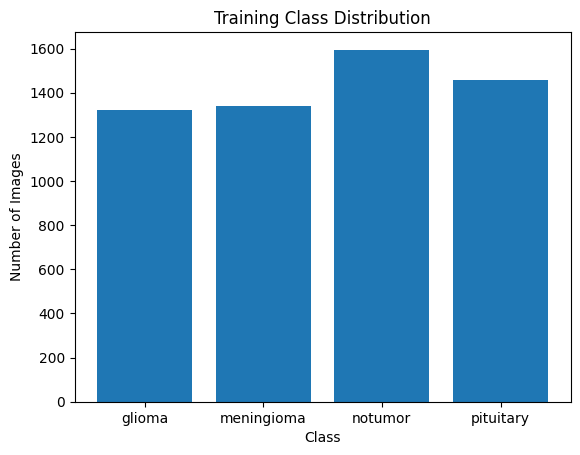

In [3]:
classes = training_data.class_names
class_counts = {name: 0 for name in classes}

for _, labels in training_data:
    for label in labels.numpy():
        class_idx = np.argmax(label) if len(label.shape) > 0 and len(label) > 1 else label
        class_counts[classes[class_idx]] += 1

print("Training classes count:")
print(class_counts)

plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.title("Training Class Distribution")
plt.show()

Perceptual Hashing to detect and remove duplicates within and between the two datasets.

Following https://pyimagesearch.com/2020/04/20/detect-and-remove-duplicate-images-from-a-dataset-for-deep-learning/

In [4]:

# --- dHash (PyImageSearch-style) ---
def dhash(image, hashSize=8):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    resized = cv2.resize(gray, (hashSize + 1, hashSize))
    diff = resized[:, 1:] > resized[:, :-1]
    return sum(2 ** i for i, v in enumerate(diff.flatten()) if v)

# --- Hash all images in a folder; return {hash: [paths,...]} ---
def hash_folder(folder):
    hashes = defaultdict(list)
    for p in paths.list_images(folder):
        # only accept common image extensions
        ext = os.path.splitext(p)[1].lower()
        if ext not in {".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff"}:
            continue
        try:
            img = cv2.imread(p)
            if img is None:
                continue
            h = dhash(img)
            hashes[h].append(p)
        except Exception:
            # skip unreadable/corrupt files gracefully
            continue
    return hashes

# --- Remove within-folder duplicates; keep first path in each group ---
def remove_within_duplicates(hashes):
    removed = 0
    for files in hashes.values():
        for dup in files[1:]:
            if os.path.exists(dup):
                os.remove(dup)
                removed += 1
    return removed

# --- Remove cross-duplicates: remove from test any hash also present in train ---
def remove_cross_duplicates(train_hashes, test_hashes):
    removed = 0
    shared = set(train_hashes.keys()) & set(test_hashes.keys())
    for h in shared:
        for p in test_hashes[h]:
            if os.path.exists(p):
                os.remove(p)
                removed += 1
    return removed

def run_duplicate_report(train_folder, test_folder, remove=False):
    # 1) Initial scan
    print(f"[INFO] Scanning {train_folder} and {test_folder}...")
    train_hashes = hash_folder(train_folder)
    test_hashes  = hash_folder(test_folder)

    # counts BEFORE removal
    train_dupes_before = sum(len(v)-1 for v in train_hashes.values() if len(v) > 1)
    test_dupes_before  = sum(len(v)-1 for v in test_hashes.values()  if len(v) > 1)
    cross_before = sum(min(len(train_hashes[h]), len(test_hashes[h])) for h in (set(train_hashes) & set(test_hashes)))

    print("\n[SUMMARY BEFORE REMOVAL]")
    print(f"→ Duplicates in {train_folder}: {train_dupes_before}")
    print(f"→ Duplicates in {test_folder}: {test_dupes_before}")
    print(f"→ Duplicates between both: {cross_before}")

    if not remove:
        return

    # 2) Remove within-set duplicates
    removed_train_within = remove_within_duplicates(train_hashes)
    removed_test_within  = remove_within_duplicates(test_hashes)

    # 3) Re-scan after within-set removals
    train_hashes = hash_folder(train_folder)
    test_hashes  = hash_folder(test_folder)

    # 4) Remove cross-duplicates (from test if present in train)
    removed_cross = remove_cross_duplicates(train_hashes, test_hashes)

    # 5) Final scan for report
    train_hashes = hash_folder(train_folder)
    test_hashes  = hash_folder(test_folder)
    train_dupes_after = sum(len(v)-1 for v in train_hashes.values() if len(v) > 1)
    test_dupes_after  = sum(len(v)-1 for v in test_hashes.values()  if len(v) > 1)
    cross_after = sum(min(len(train_hashes[h]), len(test_hashes[h])) for h in (set(train_hashes) & set(test_hashes)))

    print("\n[REMOVAL SUMMARY]")
    print(f"Removed within {train_folder}: {removed_train_within}")
    print(f"Removed within {test_folder}: {removed_test_within}")
    print(f"Removed cross-duplicates from {test_folder}: {removed_cross}")

    print("\n[SUMMARY AFTER REMOVAL]")
    print(f"→ Duplicates in {train_folder}: {train_dupes_after}")
    print(f"→ Duplicates in {test_folder}: {test_dupes_after}")
    print(f"→ Duplicates between both: {cross_after}")

# ---- Run exactly once (choose ONE of these) ----
run_duplicate_report("data/Training", "data/Testing", remove=True)

[INFO] Scanning data/Training and data/Testing...

[SUMMARY BEFORE REMOVAL]
→ Duplicates in data/Training: 303
→ Duplicates in data/Testing: 42
→ Duplicates between both: 281

[REMOVAL SUMMARY]
Removed within data/Training: 303
Removed within data/Testing: 42
Removed cross-duplicates from data/Testing: 253

[SUMMARY AFTER REMOVAL]
→ Duplicates in data/Training: 0
→ Duplicates in data/Testing: 0
→ Duplicates between both: 0


In [5]:
unsplit_training_data = tf.keras.preprocessing.image_dataset_from_directory(
    "data/Training",  #directory
    image_size=(256, 256),
    batch_size=32,
    label_mode='int',
    shuffle=False,
    seed= 123)

test_data = tf.keras.preprocessing.image_dataset_from_directory(
    "data/Testing",  # directory
    image_size=(256, 256),
    batch_size=32,
    label_mode='int',
    shuffle=False,
    seed=123)

class_names = training_data.class_names
print(class_names)

Found 5409 files belonging to 4 classes.
Found 1016 files belonging to 4 classes.
['glioma', 'meningioma', 'notumor', 'pituitary']


Training classes count:
{'glioma': 1321, 'meningioma': 1333, 'notumor': 1310, 'pituitary': 1445}


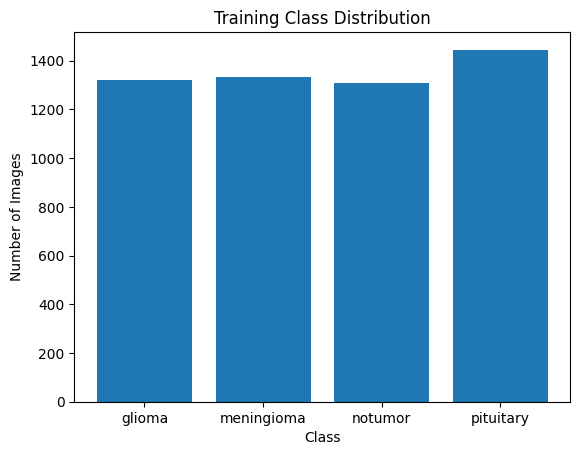

In [6]:
classes = unsplit_training_data.class_names
class_counts = {name: 0 for name in classes}

for _, labels in unsplit_training_data:
    for label in labels.numpy():
        class_idx = np.argmax(label) if len(label.shape) > 0 and len(label) > 1 else label
        class_counts[classes[class_idx]] += 1

print("Training classes count:")
print(class_counts)

plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.title("Training Class Distribution")
plt.show()

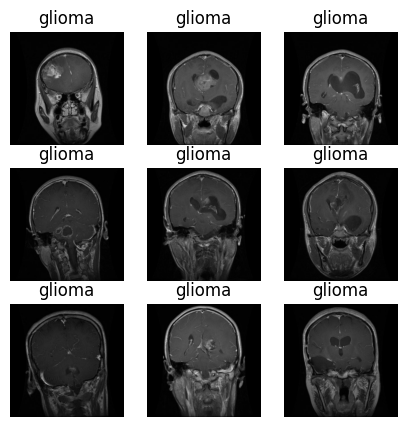

In [7]:

plt.figure(figsize=(5, 5)) # to set the figure size
for image_batch, labels_batch in unsplit_training_data.take(1): 
    for i in range(9):
        plt.subplot(3, 3, i + 1) # 3 rows, 3 columns, i+1 is the index
        plt.imshow(image_batch[i].numpy().astype("uint8")) # imshow expects a numpy 3D array
        plt.axis("off")
        plt.title(class_names[labels_batch[i]]) # to add the label

# note by default tf.keras.preprocessing.image_dataset_from_directory() will shuffle the data 
# so you get a different image each time you run the cell

In [8]:
os.environ["PYTHONHASHSEED"] = str(123)
random.seed(123)
np.random.seed(123)
tf.random.set_seed(123)

def split_train_val(data_dir, img_size=(256, 256), batch_size=32, seed=123, val_split=0.2):
    train_data = tf.keras.utils.image_dataset_from_directory(
        data_dir,
        validation_split=val_split,
        subset="training",
        seed=seed,
        image_size=img_size,
        batch_size=batch_size,
        label_mode="int",
        shuffle=True,
    )

    val_data = tf.keras.utils.image_dataset_from_directory(
        data_dir,
        validation_split=val_split,
        subset="validation",
        seed=seed,
        image_size=img_size,
        batch_size=batch_size,
        label_mode="int",
        shuffle=False,
    )
    return train_data, val_data

train_data, val_data = split_train_val("data/Training")
print(len(train_data), 'batches' , len(val_data), 'batches', len(test_data), 'batches')

Found 5409 files belonging to 4 classes.
Using 4328 files for training.
Found 5409 files belonging to 4 classes.
Using 1081 files for validation.
136 batches 34 batches 32 batches


In [9]:
# saving split data 

os.makedirs("split_data", exist_ok=True)


# Save train set
for i, (images, labels) in enumerate(train_data):
    for j in range(images.shape[0]):
        label = labels[j].numpy()
        class_dir = f"split_data/Train/{class_names[label]}"
        os.makedirs(class_dir, exist_ok=True)
        img = Image.fromarray(images[j].numpy().astype("uint8"))
        img.save(f"{class_dir}/img_{i}_{j}.jpg")

# Save val set
for i, (images, labels) in enumerate(val_data):
    for j in range(images.shape[0]):
        label = labels[j].numpy()
        class_dir = f"split_data/Val/{class_names[label]}"
        os.makedirs(class_dir, exist_ok=True)
        img = Image.fromarray(images[j].numpy().astype("uint8"))
        img.save(f"{class_dir}/img_{i}_{j}.jpg")

Move test data to the split_data folder and then zip all three train, val & test

In [10]:
for images, labels in train_data.take(1):
    print(type(images))  
    print(type(labels))   
    print(images.shape)   
    print(labels.shape)   

<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
(32, 256, 256, 3)
(32,)


Each data is a tuple containing the image as a 4D tensor (32, 256, 256, 3) and its label as a 1D tensor (32,) which contains labels from 0-3

In [12]:
# sending data to S3--- 
# ZIP TRAIN and VAL FILES IN DATA FOLDER FIRST
# AND ADD A ZIPPED TEST FILE

prefix = 'sagemaker/cnn_brain_tumor_project'

s3_train_path = sess.upload_data('split_data/Train.zip', bucket=bucket, key_prefix=prefix)
s3_val_path = sess.upload_data('split_data/Val.zip', bucket=bucket, key_prefix=prefix)
s3_test_path = sess.upload_data('split_data/Test.zip', bucket=bucket, key_prefix=prefix)

print(s3_train_path)  
print(s3_val_path)  
print(s3_test_path)  

s3://cnnmodelbucketforsagemaker/sagemaker/cnn_brain_tumor_project/Train.zip
s3://cnnmodelbucketforsagemaker/sagemaker/cnn_brain_tumor_project/Val.zip
s3://cnnmodelbucketforsagemaker/sagemaker/cnn_brain_tumor_project/Test.zip


In [ ]:
%%writefile script.py


import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from tensorflow.keras import layers, models
import os, argparse, json, zipfile
from sklearn.metrics import confusion_matrix, classification_report


# unzip data files in S3 bucket 
def unzip(zip_path, out_dir):
    os.makedirs(out_dir, exist_ok=True)
    if zip_path and os.path.exists(zip_path):
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(out_dir)
    return out_dir


# turn images into tf datasets to keep consistent with our previous code
def build_ds(image_paths, img_size=(256, 256), batch_size=32, shuffle=True):
    return tf.keras.utils.image_dataset_from_directory(
        image_paths,
        labels="inferred", #copy labels from directory structure
        label_mode="int",  #the labels are integers 0,1,2,3
        image_size=img_size,
        batch_size=batch_size,
        shuffle=shuffle,
        seed=123,
    )




# CNN model

def cnn_model(img_size=(256,256), drop=0.4, num_classes=4):
    resize_and_rescale = tf.keras.Sequential([
        layers.Resizing(img_size[0], img_size[1]),
        layers.Rescaling(1.0/255)
    ])
    data_augmentation = tf.keras.Sequential([
        layers.RandomFlip("horizontal", seed=123),   
        layers.RandomRotation(0.05, seed=123),       
        layers.RandomZoom(0.10, seed=123),           
        layers.RandomTranslation(0.05, 0.05, seed=123),  
        layers.RandomContrast(0.10, seed=123),       
    ])




    model = models.Sequential([
        resize_and_rescale,
        data_augmentation,


        layers.Conv2D(32, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(32, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        
        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(128, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(128, (3,3), activation='relu', padding='same'),

        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(drop),
        layers.Dense(num_classes, activation='softmax'),

    ])

    model.compile(
        optimizer='adam',
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics=['accuracy']
    )
    return model



if __name__ == "__main__":

    print("[INFO] Extracting arguments")
    parser = argparse.ArgumentParser()

    # create environment variables to create folderes to store train, val, test data and for the output trained model
    parser.add_argument("--model_dir",  default=os.environ.get("SM_MODEL_DIR"))     
    parser.add_argument("--train",      default=os.environ.get("SM_CHANNEL_TRAIN"))
    parser.add_argument("--validation", default=os.environ.get("SM_CHANNEL_VALIDATION"))
    parser.add_argument("--test",       default=os.environ.get("SM_CHANNEL_TEST"))

    # the file names inside the train, val and test folders to store the corresponding data
    parser.add_argument("--train-file", default="Train.zip")
    parser.add_argument("--val-file",   default="Val.zip")
    parser.add_argument("--test-file",  default="Test.zip")

    # Hyperparameters
    parser.add_argument("--epochs", type=int, default=30)
    parser.add_argument("--batch-size", type=int, default=32)
    parser.add_argument("--img-size", type=int, nargs=2, default=[256, 256]) # nargs= #arguments= 2 

    args, _ = parser.parse_known_args()
    img_size = tuple(args.img_size)    # turn list argument [] into tuple ()

    print("Tensorflow Version: ", tf.__version__)


    # 1) Unzip channels
    print("[INFO] Unzipping training, validation, and test data...")
    print()
    train_root = unzip(os.path.join(args.train, args.train_file), os.path.join(args.train, "unzipped"))
    val_root   = unzip(os.path.join(args.validation, args.val_file), os.path.join(args.validation, "unzipped"))
    test_root  = unzip(os.path.join(args.test, args.test_file), os.path.join(args.test, "unzipped"))

    # 2) Build datasets (expects class-subfolders in each root)
    print("[INFO] Building datasets...")
    print()
    train_ds = build_ds(train_root, img_size, args.batch_size, shuffle=True)
    val_ds   = build_ds(val_root,   img_size, args.batch_size, shuffle=False)
    test_ds  = build_ds(test_root,  img_size, args.batch_size, shuffle=False)

    AUTOTUNE = tf.data.AUTOTUNE
    train_ds = train_ds.cache().shuffle(1000).prefetch(AUTOTUNE)
    val_ds   = val_ds.cache().prefetch(AUTOTUNE)
    test_ds  = test_ds.cache().prefetch(AUTOTUNE)

    class_names = train_ds.class_names
    num_classes = len(class_names)
    print("Class names:", class_names)
    print()

    print("Data shape: ")
    print()
    print("Shape of Training Data:")
    print(train_ds.element_spec)
    print()
    print("Shape of Validation Data:")
    print(val_ds.element_spec)
    print()
    print("Shape of Test Data:")
    print(test_ds.element_spec)
    print()

    # 3) Build & train your CNN
    print("[INFO] Building CNN model...")
    print()
    model = cnn_model(img_size=img_size, num_classes=num_classes)
    history = model.fit(train_ds, validation_data=val_ds, epochs=args.epochs, verbose=1)  # keep history
    print()

    # Plot learning curves
    train_acc = history.history['accuracy']
    train_loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()

    # Save plot to model_dir 
    os.makedirs(args.model_dir, exist_ok=True)
    plt.savefig(os.path.join(args.model_dir, "learning_curves.png"))
    plt.close()
    print()

    model_path = os.path.join(args.model_dir, "model")
    print("[INFO] Saving model to:", model_path)
    print()

    # 4) Evaluate on test data
    metrics = model.evaluate(test_ds, verbose=2)
    print("Test metrics:", dict(zip(model.metrics_names, metrics)))
    print()
    

    # Get predictions for test set
    y_true = np.concatenate([y.numpy() for x, y in test_ds], axis=0)
    y_pred = np.argmax(model.predict(test_ds), axis=1)

    # Print confusion matrix
    print("Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred))

    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))



    # 5) Save model + class names
    os.makedirs(args.model_dir, exist_ok=True)
    export_dir = os.path.join(args.model_dir, "1")   # TF Serving expects versioned folder
    tf.saved_model.save(model, export_dir)
    with open(os.path.join(args.model_dir, "class_names.json"), "w") as f:
        json.dump(class_names, f)

Writing script.py


In [17]:
from sagemaker.tensorflow import TensorFlow

role = "arn:aws:iam::111311034112:role/cnn_brain_tumour_ARN_role"  

tensorflow_estimator = TensorFlow(
    entry_point="script.py",
    role=role,
    instance_count=1,
    instance_type="ml.g4dn.12xlarge",     
    framework_version="2.14.1",
    py_version="py310",
    base_job_name="cnn-brain-tumor",
    hyperparameters={"epochs": 30, "batch-size": 32, "img-size": [256, 256]},
    use_spot_instances=False,          # avoid spot quota issues
    max_run=3600,
    dependencies=["requirements_sagemaker.txt"],
)

tensorflow_estimator.fit(
    {"train": s3_train_path, "validation": s3_val_path, "test": s3_test_path},
    wait=True
)

INFO:sagemaker.telemetry.telemetry_logging:SageMaker Python SDK will collect telemetry to help us better understand our user's needs, diagnose issues, and deliver additional features.
To opt out of telemetry, please disable via TelemetryOptOut parameter in SDK defaults config. For more information, refer to https://sagemaker.readthedocs.io/en/stable/overview.html#configuring-and-using-defaults-with-the-sagemaker-python-sdk.
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: cnn-brain-tumor-2025-08-18-19-59-27-791


2025-08-18 19:59:32 Starting - Starting the training job
2025-08-18 19:59:32 Pending - Training job waiting for capacity.........
2025-08-18 20:00:54 Pending - Preparing the instances for training...
2025-08-18 20:01:39 Downloading - Downloading the training image..................
2025-08-18 20:04:41 Training - Training image download completed. Training in progress.../usr/local/lib/python3.10/site-packages/paramiko/pkey.py:100: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "cipher": algorithms.TripleDES,
/usr/local/lib/python3.10/site-packages/paramiko/transport.py:259: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "class": algorithms.TripleDES,
2025-08-18 20:05:16.010045: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:19                                                                                   │
│                                                                                                  │
│   16 │   dependencies=["requirements_sagemaker.txt"],                                            │
│   17 )                                                                                           │
│   18                                                                                             │
│ ❱ 19 tensorflow_estimator.fit(                                                                   │
│   20 │   {"train": s3_train_path, "validation": s3_val_path, "test": s3_test_path},              │
│   21 │   wait=True                                                                               │
│   22 )                                                                                           │
│                                                                                                  │
│ /Users/marwa/Desktop/CNN_Brain_Tumor/mycnnexenv/lib/python3.10/site-packages/sagemaker/telemetry │
│ /telemetry_logging.py:168 in wrapper                                                             │
│                                                                                                  │
│   165 │   │   │   │   │   caught_ex = e                                                          │
│   166 │   │   │   │   finally:                                                                   │
│   167 │   │   │   │   │   if caught_ex:                                                          │
│ ❱ 168 │   │   │   │   │   │   raise caught_ex                                                    │
│   169 │   │   │   │   │   return response  # pylint: disable=W0150                               │
│   170 │   │   │   else:                                                                          │
│   171 │   │   │   │   logger.debug(                                                              │
│                                                                                                  │
│ /Users/marwa/Desktop/CNN_Brain_Tumor/mycnnexenv/lib/python3.10/site-packages/sagemaker/telemetry │
│ /telemetry_logging.py:139 in wrapper                                                             │
│                                                                                                  │
│   136 │   │   │   │   start_timer = perf_counter()                                               │
│   137 │   │   │   │   try:                                                                       │
│   138 │   │   │   │   │   # Call the original function                                           │
│ ❱ 139 │   │   │   │   │   response = func(*args, **kwargs)                                       │
│   140 │   │   │   │   │   stop_timer = perf_counter()                                            │
│   141 │   │   │   │   │   elapsed = stop_timer - start_timer                                     │
│   142 │   │   │   │   │   extra += f"&x-latency={round(elapsed, 2)}"                             │
│                                                                                                  │
│ /Users/marwa/Desktop/CNN_Brain_Tumor/mycnnexenv/lib/python3.10/site-packages/sagemaker/workflow/ │
│ pipeline_context.py:346 in wrapper                                                               │
│                                                                                                  │
│   343 │   │   │                                                                                  │
│   344 │   │   │   return _StepArguments(retrieve_caller_name(self_instance), run_func, *args,    │
│   345 │   │                                                                                      │
│ ❱ 346 │   │   return run_func(*args, **kwargs)             